# Capstone Project: The Battle of Neighbourhoods


by Fais Chalo

## 1. Introduction


### 1.1. Problem Description

Visiting a new city which seems to be to big to explore all in once is a problem when it comes to metropolies like London. Through a wide range of different cultures London developent economically, socially and politcially.

One great aspect of the diversity is the wide range of different eating possibilities.

But since it can be quite hard to distinguish between a good and bad restaurant and which one to choose there should be parameters in consideration to easen up the search. In my todays analysis i want to take the case of african food restaurants in London, which i recently heard of are quite popular. 

### 1.2 Background and Motivation

Since my coworker is from Ghana and we recently got a new colleague from Senegal, my interest for the african food quitly increased since there are bringing all kind of delicious food to work. 

My Ghanese coworker mentioned therefore that he is thinking about opening a Ghanese restaurant in London, but isn't quite sure about the current information provided.

Therefore i will lend him a hand in providing a deep analysis about the possibilities.

### 1.3. Possible Audience

Like i mentioned there is a high range of diversity in London and so we can conclude that besides the tourist also locals could be highly interested in finding the most visitable restaurant in whole london. Therefore the target audience are people who care about a high sophisticated african restaurant with high quality standarts.

## 2. Data


### 2.1 Description of Data 

In my Analysis i will take data from the sites Wikipedia and Foursquare.

**Dataset 1**

In this dataset i will examine data from the Areas of London which was provided by wikipedia.

The London Area has 32 Boroughs and the "City of London". You can find the data here - Greater London Area <https://en.wikipedia.org/wiki/List_of_areas_of_London >


In [2]:
# library for BeautifulSoup
from bs4 import BeautifulSoup

# library to handle data in a vectorized manner
import numpy as np

# library for data analsysis
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# library to handle JSON files
import json
print('numpy, pandas, ..., imported...')

!pip -q install geopy
# conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
print('geopy installed...')
# convert an address into latitude and longitude values
from geopy.geocoders import Nominatim
print('Nominatim imported...')

# library to handle requests
import requests
print('requests imported...')

# tranform JSON file into a pandas dataframe
from pandas.io.json import json_normalize
print('json_normalize imported...')

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
print('matplotlib imported...')

# import k-means from clustering stage
from sklearn.cluster import KMeans
print('Kmeans imported...')

# install the Geocoder
!pip -q install geocoder
import geocoder

# import time
import time

# !conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
!pip -q install folium
print('folium installed...')
import folium # map rendering library
print('folium imported...')
print('...Done')

numpy, pandas, ..., imported...
geopy installed...
Nominatim imported...
requests imported...
json_normalize imported...
matplotlib imported...
Kmeans imported...
folium installed...
folium imported...
...Done


In [3]:
wikipedia_link = 'https://en.wikipedia.org/wiki/List_of_areas_of_London'
headers = {'User-Agent': 'Chrome/5.0 (Windows 10.0; Win64; x64; rv:64.0) Fais/ Chrome/64.0'}
wikipedia_page = requests.get(wikipedia_link, headers = headers)
wikipedia_page

<Response [200]>

In [4]:
# First you need to clean html file and extract the "tbody" within the table where class is "wikitable sortable"

soup = BeautifulSoup(wikipedia_page.content, 'html.parser')
table = soup.find('table', {'class':'wikitable sortable'}).tbody

In [5]:
# Extracts all "tr" (table rows) within the table above
rows = table.find_all('tr')
# Extracts the column headers, removes and replaces possible '\n' with space for the "th" tag
columns = [i.text.replace('\n', '')
           for i in rows[0].find_all('th')]
# Converts columns to pd dataframe
df = pd.DataFrame(columns = columns)
df

,Location,London borough,Post town,Postcode district,Dial code,OS grid ref


In [6]:
# Extracts every row with corresponding columns, then append the values to the created pd dataframe "df"

for i in range(1, len(rows)):
    tds = rows[i].find_all('td')
    
    
    if len(tds) == 7:
        values = [tds[0].text, tds[1].text, tds[2].text.replace('\n', ''.replace('\xa0','')), tds[3].text, tds[4].text.replace('\n', ''.replace('\xa0','')), tds[5].text.replace('\n', ''.replace('\xa0','')), tds[6].text.replace('\n', ''.replace('\xa0',''))]
    else:
        values = [td.text.replace('\n', '').replace('\xa0','') for td in tds]
        
        df = df.append(pd.Series(values, index = columns), ignore_index = True)

        df

In [7]:
df.head(5)

,Location,London borough,Post town,Postcode district,Dial code,OS grid ref
0,Abbey Wood,"Bexley, Greenwich [1]",LONDON,SE2,020,TQ465785
1,Acton,"Ealing, Hammersmith and Fulham[2]",LONDON,"W3, W4",020,TQ205805
2,Addington,Croydon[2],CROYDON,CR0,020,TQ375645
3,Addiscombe,Croydon[2],CROYDON,CR0,020,TQ345665
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728


In [8]:
df = df.rename(index=str, columns = {'Location': 'Location', 'London\xa0borough': 'Borough', 'Post town': 'Post-town', 'Postcode\xa0district': 'Postcode', 'Dial\xa0code': 'Dial-code', 'OS grid ref': 'OSGridRef'})

In [9]:
df.head(5)

,Location,Borough,Post-town,Postcode,Dial-code,OSGridRef
0,Abbey Wood,"Bexley, Greenwich [1]",LONDON,SE2,020,TQ465785
1,Acton,"Ealing, Hammersmith and Fulham[2]",LONDON,"W3, W4",020,TQ205805
2,Addington,Croydon[2],CROYDON,CR0,020,TQ375645
3,Addiscombe,Croydon[2],CROYDON,CR0,020,TQ345665
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728


Under our column Borough we see signs: []. Since this are wikipedias references and are not useful for our analysis we should remove them:

In [10]:
df['Borough'] = df['Borough'].map(lambda x: x.rstrip(']').rstrip('0123456789').rstrip('['))

In [11]:
df.shape

(533, 6)

In [12]:
df.head(5)

,Location,Borough,Post-town,Postcode,Dial-code,OSGridRef
0,Abbey Wood,"Bexley, Greenwich",LONDON,SE2,020,TQ465785
1,Acton,"Ealing, Hammersmith and Fulham",LONDON,"W3, W4",020,TQ205805
2,Addington,Croydon,CROYDON,CR0,020,TQ375645
3,Addiscombe,Croydon,CROYDON,CR0,020,TQ345665
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728


Since our Foursquare limits of 100 calls a day we need to choose one district of London. Further on we need to make some assumptions for our dataset (Note A=Assumption)

 A1: As we can see in our postcode column there can be 2 values which probably have individually the same value for each.

In [13]:
df0 = df.drop('Postcode', axis=1).join(df['Postcode'].str.split(',', expand=True).stack().reset_index(level=1, drop=True).rename('Postcode'))

In [14]:
df0.head(5)


,Location,Borough,Post-town,Dial-code,OSGridRef,Postcode
0,Abbey Wood,"Bexley, Greenwich",LONDON,020,TQ465785,SE2
1,Acton,"Ealing, Hammersmith and Fulham",LONDON,020,TQ205805,W3
1,Acton,"Ealing, Hammersmith and Fulham",LONDON,020,TQ205805,W4
10,Angel,Islington,LONDON,020,TQ345665,EC1
10,Angel,Islington,LONDON,020,TQ345665,N1


In [15]:
df0.shape

(638, 6)

Our A1 was correct, so now we have seperated the equal values.

A2: From the data, only the 'Location', 'Borough', 'Postcode', 'Post-town' will be used for this project. Therefore we need to create a new 

In [16]:
df1 = df0[['Location', 'Borough', 'Postcode', 'Post-town']].reset_index(drop=True)

In [17]:
df1.head(5)

,Location,Borough,Postcode,Post-town
0,Abbey Wood,"Bexley, Greenwich",SE2,LONDON
1,Acton,"Ealing, Hammersmith and Fulham",W3,LONDON
2,Acton,"Ealing, Hammersmith and Fulham",W4,LONDON
3,Angel,Islington,EC1,LONDON
4,Angel,Islington,N1,LONDON


In [18]:
df1.shape

(638, 4)

A3: We now selectec only Post-town for the selection search. Therefore, all the non-post-town are dropped.

In [19]:
df2 = df1
df21 = df2[df2['Post-town'].str.contains('LONDON')]

In [20]:
df21.head(5)

,Location,Borough,Postcode,Post-town
0,Abbey Wood,"Bexley, Greenwich",SE2,LONDON
1,Acton,"Ealing, Hammersmith and Fulham",W3,LONDON
2,Acton,"Ealing, Hammersmith and Fulham",W4,LONDON
3,Angel,Islington,EC1,LONDON
4,Angel,Islington,N1,LONDON


In [21]:
df21.shape

(380, 4)

From A3 , we only have 380 cases instead of 638, which is a high drop.

In [22]:
# Re-assigns the df21 to new dataframe without the Post-town
df3 = df21[['Location', 'Borough', 'Postcode']].reset_index(drop=True)

In [23]:
df3.head(10)

,Location,Borough,Postcode
0,Abbey Wood,"Bexley, Greenwich",SE2
1,Acton,"Ealing, Hammersmith and Fulham",W3
2,Acton,"Ealing, Hammersmith and Fulham",W4
3,Angel,Islington,EC1
4,Angel,Islington,N1
5,Church End,Brent,NW10
6,Church End,Barnet,N3
7,Clapham,"Lambeth, Wandsworth",SW4
8,Clerkenwell,Islington,EC1
9,Colindale,Barnet,NW9


In [24]:
df_london = df3
df_london.to_csv('LondonLocations.csv', index = False)

A4: Since the South east areas has a high diversity of African food places, we can conclude that this would be the best area to spot a restaurant.

1) So we have to delete the white spots
2) Then we need to get to take out the NON-SE areas

In [25]:
df_london.head(5)

,Location,Borough,Postcode
0,Abbey Wood,"Bexley, Greenwich",SE2
1,Acton,"Ealing, Hammersmith and Fulham",W3
2,Acton,"Ealing, Hammersmith and Fulham",W4
3,Angel,Islington,EC1
4,Angel,Islington,N1


In [26]:
df_london.Postcode = df_london.Postcode.str.strip()

In [27]:
df_london.head(5)

,Location,Borough,Postcode
0,Abbey Wood,"Bexley, Greenwich",SE2
1,Acton,"Ealing, Hammersmith and Fulham",W3
2,Acton,"Ealing, Hammersmith and Fulham",W4
3,Angel,Islington,EC1
4,Angel,Islington,N1


In [28]:
# New dataframe for South East London postcodes - df_se
df_se = df_london[df_london['Postcode'].str.startswith(('SE'))].reset_index(drop=True)

In [29]:
df_se.head(10)

,Location,Borough,Postcode
0,Abbey Wood,"Bexley, Greenwich",SE2
1,Crofton Park,Lewisham,SE4
2,Crossness,Bexley,SE2
3,Crystal Palace,Bromley,SE19
4,Crystal Palace,Bromley,SE20
5,Crystal Palace,Bromley,SE26
6,Denmark Hill,Southwark,SE5
7,Deptford,Lewisham,SE8
8,Dulwich,Southwark,SE21
9,East Dulwich,Southwark,SE22


The Data is now **ready**.  **df_se** is the data we will focus on.


A5: Next assumption will focus on the most diverse multicultural areas of london. Below you can see the top 5 different races.

In [30]:
demograph_link = 'https://en.wikipedia.org/wiki/Demography_of_London'
headers = {'User-Agent': 'Chrome/5.0 (Windows 10.0; Win64; x64; rv:64.0) Fais/ Chrome/64.0'}
demograph_page = requests.get(demograph_link, headers = headers)
soup1 = BeautifulSoup(demograph_page.content, 'html.parser')
table1 = soup1.find('table', {'class':'wikitable sortable'}).tbody
rows1 = table1.find_all('tr')
columns1 = [i.text.replace('\n', '')
           for i in rows1[0].find_all('th')]

In [31]:
columns1

['Local authority', 'White', 'Mixed', 'Asian', 'Black', 'Other']

In [32]:
demo_london = pd.DataFrame(columns = columns1)


In [33]:
demo_london.head(5)

,Local authority,White,Mixed,Asian,Black,Other


In [34]:
for j in range(1, len(rows1)):
    tds1 = rows1[j].find_all('td')
    if len(tds1) == 7:
        values1 = [tds1[0].text, tds1[1].text, tds1[2].text.replace('\n', ''.replace('\xa0','')), tds1[3].text, tds1[4].text.replace('\n', ''.replace('\xa0','')), tds1[5].text.replace('\n', ''.replace('\xa0',''))]
    else:
        values1 = [td1.text.replace('\n', '').replace('\xa0','') for td1 in tds1]
        
        demo_london = demo_london.append(pd.Series(values1, index = columns1), ignore_index = True)

        demo_london

In [35]:
demo_london['Black'] = demo_london['Black'].astype('float')

In [36]:
demo_london_sorted = demo_london.sort_values(by='Black', ascending = False)

**Below we can see the demographic order for our analysis. Since we Lewisham has the highest range of black people we are going to use Lewisham for the analysis.**

In [37]:
demo_london_sorted.head(5)

,Local authority,White,Mixed,Asian,Black,Other
22,Lewisham,53.5,7.4,9.3,27.2,2.6
27,Southwark,54.3,6.2,9.4,26.9,3.3
21,Lambeth,57.1,7.6,6.9,25.9,2.4
11,Hackney,54.7,6.4,10.5,23.1,5.3
7,Croydon,55.1,6.6,16.4,20.2,1.8


A6: This assumption will focus on the highest focus of the races Black/Mixed, which are in Lewisham, Southwark, Lambeth, Hackney and Croydon.

In [38]:
df_se

,Location,Borough,Postcode
0,Abbey Wood,"Bexley, Greenwich",SE2
1,Crofton Park,Lewisham,SE4
2,Crossness,Bexley,SE2
3,Crystal Palace,Bromley,SE19
4,Crystal Palace,Bromley,SE20
5,Crystal Palace,Bromley,SE26
6,Denmark Hill,Southwark,SE5
7,Deptford,Lewisham,SE8
8,Dulwich,Southwark,SE21
9,East Dulwich,Southwark,SE22


In [39]:
df_se_top = df_se[df_se['Borough'].isin(['Lewisham', 'Southwark', 'Lambeth', 'Hackney', 'Croydon'])].reset_index(drop=True)

In [40]:
df_se_top.head(5)

,Location,Borough,Postcode
0,Crofton Park,Lewisham,SE4
1,Denmark Hill,Southwark,SE5
2,Deptford,Lewisham,SE8
3,Dulwich,Southwark,SE21
4,East Dulwich,Southwark,SE22


In [41]:
df_se_top.shape

(46, 3)

In [42]:
df_se.shape

(80, 3)

So we have our working dataframe to be df_se_top to work with.



### 2.1.2 Dataset 2:


We will use the Foursquare API to locate the places of neighbourhoods of London.

The places will provide the categories needed for the analysis. Checking through the categories we can answer the question which restaurant is in favor of another one.

In [48]:
# Geocoder starts here
# Defining a function to use --> get_latlng()'''
def get_latlng(arcgis_geocoder):
    
    # Initialize the Location (lat. and long.) to "None"
    lat_lng_coords = None
    
    # While loop helps to create a continous run until all the location coordinates are geocoded
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, London, United Kingdom'.format(arcgis_geocoder))
        lat_lng_coords = g.latlng
    return lat_lng_coords
# Geocoder ends here

Testing for SE2 below



In [49]:
sample = get_latlng('SE2')
sample

[51.492450000000076, 0.12127000000003818]

And reverse geocoding this, using the geocodefarm geocoder, gives the following:



In [50]:
gg = geocoder.geocodefarm(sample, method = 'reverse')
gg

Status code Unknown from https://www.geocode.farm/v3/json/reverse/: ERROR - HTTPSConnectionPool(host='www.geocode.farm', port=443): Max retries exceeded with url: /v3/json/reverse/?lat=51.492450000000076&lon=0.12127000000003818&lang=&country= (Caused by SSLError(SSLError("bad handshake: Error([('SSL routines', 'tls_process_server_certificate', 'certificate verify failed')],)",),))


<[ERROR - HTTPSConnectionPool(host='www.geocode.farm', port=443): Max retries exceeded with url: /v3/json/reverse/?lat=51.492450000000076&lon=0.12127000000003818&lang=&country= (Caused by SSLError(SSLError("bad handshake: Error([('SSL routines', 'tls_process_server_certificate', 'certificate verify failed')],)",),))] Geocodefarm - Reverse [empty]>

So, we are certain that the geocoder works fine. So we proceed to applying it to our dataframe df_se_top.

In [51]:
start = time.time()

postal_codes = df_se_top['Postcode']    
coordinates = [get_latlng(postal_code) for postal_code in postal_codes.tolist()]

end = time.time()
print("Time of execution: ", end - start, "seconds")

Time of execution:  25.61745595932007 seconds


Then we proceed to store the location data - latitude and longitude as follows. The obtained coordinates are then joined to df_se_topto create new data frame.

In [52]:
df_se_loc = df_se_top

# The obtained coordinates (latitude and longitude) are joined with the dataframe as shown
df_se_coordinates = pd.DataFrame(coordinates, columns = ['Latitude', 'Longitude'])
df_se_loc['Latitude'] = df_se_coordinates['Latitude']
df_se_loc['Longitude'] = df_se_coordinates['Longitude']

In [53]:
df_se_loc.head(5)


,Location,Borough,Postcode,Latitude,Longitude
0,Crofton Park,Lewisham,SE4,51.46268,-0.03558
1,Denmark Hill,Southwark,SE5,51.47478,-0.09312
2,Deptford,Lewisham,SE8,51.48117,-0.02476
3,Dulwich,Southwark,SE21,51.44100,-0.08897
4,East Dulwich,Southwark,SE22,51.45256,-0.07076


In [54]:
df_se_loc.to_csv('SELondonLocationsCoordinates.csv', index = False)

In [55]:
df_se_loc.shape

(46, 5)

### 2.1.3 Dataset 3:


We will use the Foursquare API to locate the places of neighbourhoods of London.

The places will provide the categories needed for the analysis. Checking through the categories we can answer the question which restaurant is in favor of another one.

In [57]:

CLIENT_ID = 'EXVKUTOT2BERMNXDZWS5XPOHNVUZRKH02LIR45UI0CKHL5I1' # your Foursquare ID
CLIENT_SECRET = '34RGZGLLGGADMEKDFO2HINEOK51LRGKFBPOFIJHEF5CQE42O' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: EXVKUTOT2BERMNXDZWS5XPOHNVUZRKH02LIR45UI0CKHL5I1
CLIENT_SECRET:34RGZGLLGGADMEKDFO2HINEOK51LRGKFBPOFIJHEF5CQE42O


## 3. Methology


### 3. Exploring of Data


**3.1.1 Single Neighbourhood**


1) For Our Analysis we first check the single neighbourhood case to check wheter the api Foursquare connection works out. We use Lewisham Borough postocde  SE13 and the Lewisham location for it.

In [58]:
# Resets the current index to a new
se_df = df_se_loc.reset_index().drop('index', axis = 1)

In [59]:
se_df.shape


(46, 5)

In [60]:
se_df


,Location,Borough,Postcode,Latitude,Longitude
0,Crofton Park,Lewisham,SE4,51.46268,-0.03558
1,Denmark Hill,Southwark,SE5,51.47478,-0.09312
2,Deptford,Lewisham,SE8,51.48117,-0.02476
3,Dulwich,Southwark,SE21,51.44100,-0.08897
4,East Dulwich,Southwark,SE22,51.45256,-0.07076
5,Elephant and Castle,Southwark,SE1,51.49960,-0.09613
6,Elephant and Castle,Southwark,SE11,51.49085,-0.11108
7,Elephant and Castle,Southwark,SE17,51.48764,-0.09542
8,Bankside,Southwark,SE1,51.49960,-0.09613
9,Forest Hill,Lewisham,SE23,51.44122,-0.04764


In [61]:
se_df.loc[se_df['Location'] == 'Lewisham']


,Location,Borough,Postcode,Latitude,Longitude
20,Lewisham,Lewisham,SE13,51.46196,-0.00754


Check now leisham with the location of **20**

In [62]:
se_df.loc[20, 'Location']


'Lewisham'

In [63]:
lewisham_lat = se_df.loc[20, 'Latitude']
lewisham_long = se_df.loc[20, 'Longitude']
lewisham_loc = se_df.loc[20, 'Location']
lewisham_postcode = se_df.loc[20, 'Postcode']

print('The latitude and longitude values of {} with postcode {}, are {}, {}.'.format(lewisham_loc,
                                                                                         lewisham_postcode,
                                                                                         lewisham_lat,
                                                                                         lewisham_long))

The latitude and longitude values of Lewisham with postcode SE13, are 51.46196000000003, -0.007539999999949032.


Lets check the top 100 venues that are within a 200 metres radius of Lewisham

In [64]:

# Credentials are provided already for this part
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 2000 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    lewisham_lat, 
    lewisham_long, 
    radius, 
    LIMIT)

# displays URL
url

'https://api.foursquare.com/v2/venues/explore?&client_id=EXVKUTOT2BERMNXDZWS5XPOHNVUZRKH02LIR45UI0CKHL5I1&client_secret=34RGZGLLGGADMEKDFO2HINEOK51LRGKFBPOFIJHEF5CQE42O&v=20180604&ll=51.46196000000003,-0.007539999999949032&radius=2000&limit=100'

Then, send the GET request and examine the results.



In [65]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5cf247f4f594df57ed9856f3'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Lewisham Central',
  'headerFullLocation': 'Lewisham Central, London',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 181,
  'suggestedBounds': {'ne': {'lat': 51.47996001800005,
    'lng': 0.021296961190459426},
   'sw': {'lat': 51.44395998200002, 'lng': -0.03637696119035749}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '535823bc498ec8d8da9aad5f',
       'name': 'Street Feast Model Market',
       'location': {'address': '196 Lewisham High St',
        'crossStreet': 'entrance at Molesworth St',
        'lat': 51.46020945743763,
        'lng': -0.01

The necessary information is contained in item keys . Therefore we use the get_category_type function from the Foursquare lab to extract these.

In [66]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [67]:

venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

In [68]:
nearby_venues


,name,categories,lat,lng
0,Street Feast Model Market,Street Food Gathering,51.460209,-0.012199
1,Maggie's Kitchen,Café,51.465380,-0.011213
2,Levante restaurant,Restaurant,51.462072,-0.009491
3,Gennaro Delicatessan,Deli / Bodega,51.461765,-0.009726
4,Levante Pide Restaurant,Turkish Restaurant,51.459848,-0.011476
5,Manor House Gardens,Park,51.456686,0.004684
6,Corte,Coffee Shop,51.459776,-0.011554
7,Everest Curry King,Sri Lankan Restaurant,51.466012,-0.019656
8,Blackheath Farmers' Market,Farmers Market,51.465913,0.007945
9,Côte Brasserie,French Restaurant,51.467378,0.007176


In [69]:
nearby_venues_lewisham_unique = nearby_venues['categories'].value_counts().to_frame(name='Count')


**Lets check how categories are veloped in the area of lewisham which is our area of analysis.**

In [70]:
nearby_venues_lewisham_unique.head(5)


,Count
Pub,13
Café,9
Gastropub,7
Park,6
Coffee Shop,5


This results clearly show that even though there restaurants in lewisham area, they are not in the top 5 count.

In [71]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))


100 venues were returned by Foursquare.


**3.1.2 Multiple Neighborhood**


In this part of the analysis we will check for multiple neighborhood case.

In [73]:
def getNearbyVenues(names, latitudes, longitudes, radius=2000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

We use the function getNearbyVenues for each neighboorhood. Then we create a new dataframe called london_venues.

In [74]:
se_venues = getNearbyVenues(names=se_df['Location'],
                                   latitudes=se_df['Latitude'],
                                   longitudes=se_df['Longitude']
                                  )

Crofton Park
Denmark Hill
Deptford
Dulwich
East Dulwich
Elephant and Castle
Elephant and Castle
Elephant and Castle
Bankside
Forest Hill
Gipsy Hill
Gipsy Hill
Grove Park
Herne Hill
Hither Green
Honor Oak
Ladywell
Ladywell
Lambeth
Lee
Lewisham
New Cross
Newington
Newington
Nunhead
Oval
Bellingham
Peckham
Rotherhithe
Selhurst
Bermondsey
South Norwood
Southend
St Johns
Surrey Quays
Tulse Hill
Tulse Hill
Upper Norwood
Walworth
Blackheath
West Norwood
Brixton
Brockley
Camberwell
Catford
Chinbrook


In [75]:
se_venues.shape


(4257, 7)

In [76]:
len(se_venues)


4257

In [77]:

se_venues['Neighbourhood'].value_counts()
se_venues.to_csv('se_venues.csv')

In [78]:
se_venues.head(5)


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Crofton Park,51.46268,-0.03558,The Orchard,51.463678,-0.035699,Gastropub
1,Crofton Park,51.46268,-0.03558,Saka Maka,51.464826,-0.036437,Indian Restaurant
2,Crofton Park,51.46268,-0.03558,Brockley's Rock,51.459457,-0.033868,Fish & Chips Shop
3,Crofton Park,51.46268,-0.03558,Browns Of Brockley,51.464513,-0.037346,Coffee Shop
4,Crofton Park,51.46268,-0.03558,waterintobeer,51.463712,-0.038826,Beer Store


Now we examine The number of venues returned for each neighbourhoods is then explored as follows:



In [79]:
se_venues.groupby('Neighbourhood').count()


,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Bankside,100,100,100,100,100,100
Bellingham,67,67,67,67,67,67
Bermondsey,100,100,100,100,100,100
Blackheath,92,92,92,92,92,92
Brixton,100,100,100,100,100,100
Brockley,100,100,100,100,100,100
Camberwell,100,100,100,100,100,100
Catford,67,67,67,67,67,67
Chinbrook,54,54,54,54,54,54


How many unique categories can be examined for the venues? Lets check it like this:


In [80]:
print('There are {} uniques categories.'.format(len(se_venues['Venue Category'].unique())))


There are 195 uniques categories.


In [81]:
se_venue_unique_count = se_venues['Venue Category'].value_counts().to_frame(name='Count')


**Lets check how categories are developed in multille city points instead like above for one single area.**

In [82]:
se_venue_unique_count.head(5)


,Count
Pub,425
Coffee Shop,302
Café,296
Park,221
Grocery Store,161


In [83]:
se_venue_unique_count.describe()


,Count
count,195.000000
mean,21.830769
std,49.166214
min,1.000000
25%,4.000000
50%,7.000000
75%,17.000000
max,425.000000


## 3.1. Now we start to create Clusters.

Using the geopy library, the latitude and longitude values of London is obtained.



In [84]:
address = 'London, United Kingdom'

geolocator = Nominatim(user_agent="ln_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of London are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of London are 51.5073219, -0.1276474.


To obtain coordinates, use the folium library.

In [85]:

# df_london_coordinates
map_london = folium.Map(location = [latitude, longitude], zoom_start = 12)
map_london

The South East London neighbourhoods are then superimposed on top as shown below, still using the foliumlibrary.


In [86]:
# Adding markers to map
for lat, lng, borough, loc in zip(se_df['Latitude'], 
                                  se_df['Longitude'],
                                  se_df['Borough'],
                                  se_df['Location']):
    label = '{} - {}'.format(loc, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_london)  
    
display(map_london)

In [87]:
type(se_df)


pandas.core.frame.DataFrame

**3.2.3 Lets analyse each neighborhood**


**One Hot Encoding**


In [88]:
# one hot encoding
se_onehot = pd.get_dummies(se_venues[['Venue Category']], prefix = "", prefix_sep = "")

lets add the neighborhoodcolum back to the dataframe. 

In [90]:
# add neighborhood column back to dataframe
se_onehot['Neighbourhood'] = se_venues['Neighbourhood']

We should rearange neighbooorhood to the first colum. See below.

In [91]:
# move neighborhood column to the first column
fixed_columns = [se_onehot.columns[-1]] + list(se_onehot.columns[:-1])
se_onehot = se_onehot[fixed_columns]

In [92]:
se_onehot.head(5)


,Neighbourhood,African Restaurant,American Restaurant,Antique Shop,Aquarium,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Bakery,Bar,Beer Bar,Beer Garden,Beer Store,Bike Shop,Bistro,Bookstore,Brazilian Restaurant,Breakfast Spot,Brewery,Burger Joint,Bus Stop,Café,Canal,Cantonese Restaurant,Caribbean Restaurant,Champagne Bar,Cheese Shop,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,Community Center,Concert Hall,Convenience Store,Creperie,Cricket Ground,Cupcake Shop,Dance Studio,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Himalayan Restaurant,Historic Site,History Museum,Hookah Bar,Hostel,Hotel,Hotel Bar,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Liquor Store,Malay Restaurant,Market,Massage Studio,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Modern European Restaurant,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,Nature Preserve,Nightclub,Observatory,Okonomiyaki Restaurant,Outdoor Sculpture,Pakistani Restaurant,Park,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Pizza Place,Planetarium,Platform,Playground,Plaza,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Pub,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Restaurant,Rugby Pitch,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shopping Mall,Shopping Plaza,Skate Park,Soccer Field,Soccer Stadium,Social Club,Spanish Restaurant,Sporting Goods Shop,Sri Lankan Restaurant,Stadium,Steakhouse,Street Art,Street Food Gathering,Supermarket,Sushi Restaurant,Taco Place,Tapas Restaurant,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Track,Trail,Train Station,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Warehouse Store,Windmill,Wine Bar,Xinjiang Restaurant,Yoga Studio,Zoo Exhibit
0,Crofton Park,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Crofton Park,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Crofton Park,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [93]:
se_onehot.loc[se_onehot['African Restaurant'] != 0]


,Neighbourhood,African Restaurant,American Restaurant,Antique Shop,Aquarium,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Bakery,Bar,Beer Bar,Beer Garden,Beer Store,Bike Shop,Bistro,Bookstore,Brazilian Restaurant,Breakfast Spot,Brewery,Burger Joint,Bus Stop,Café,Canal,Cantonese Restaurant,Caribbean Restaurant,Champagne Bar,Cheese Shop,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,Community Center,Concert Hall,Convenience Store,Creperie,Cricket Ground,Cupcake Shop,Dance Studio,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Himalayan Restaurant,Historic Site,History Museum,Hookah Bar,Hostel,Hotel,Hotel Bar,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Liquor Store,Malay Restaurant,Market,Massage Studio,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Modern European Restaurant,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,Nature Preserve,Nightclub,Observatory,Okonomiyaki Restaurant,Outdoor Sculpture,Pakistani Restaurant,Park,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Pizza Place,Planetarium,Platform,Playground,Plaza,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Pub,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Restaurant,Rugby Pitch,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shopping Mall,Shopping Plaza,Skate Park,Soccer Field,Soccer Stadium,Social Club,Spanish Restaurant,Sporting Goods Shop,Sri Lankan Restaurant,Stadium,Steakhouse,Street Art,Street Food Gathering,Supermarket,Sushi Restaurant,Taco Place,Tapas Restaurant,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Track,Trail,Train Station,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Warehouse Store,Windmill,Wine Bar,Xinjiang Restaurant,Yoga Studio,Zoo Exhibit
133,Denmark Hill,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
657,Elephant and Castle,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
739,Elephant and Castle,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [94]:
se_onehot.loc[se_onehot['Neighbourhood'] == 'Lewisham']


,Neighbourhood,African Restaurant,American Restaurant,Antique Shop,Aquarium,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Bakery,Bar,Beer Bar,Beer Garden,Beer Store,Bike Shop,Bistro,Bookstore,Brazilian Restaurant,Breakfast Spot,Brewery,Burger Joint,Bus Stop,Café,Canal,Cantonese Restaurant,Caribbean Restaurant,Champagne Bar,Cheese Shop,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,Community Center,Concert Hall,Convenience Store,Creperie,Cricket Ground,Cupcake Shop,Dance Studio,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Himalayan Restaurant,Historic Site,History Museum,Hookah Bar,Hostel,Hotel,Hotel Bar,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Liquor Store,Malay Restaurant,Market,Massage Studio,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Modern European Restaurant,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,Nature Preserve,Nightclub,Observatory,Okonomiyaki Restaurant,Outdoor Sculpture,Pakistani Restaurant,Park,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Pizza Place,Planetarium,Platform,Playground,Plaza,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Pub,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Restaurant,Rugby Pitch,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shopping Mall,Shopping Plaza,Skate Park,Soccer Field,Soccer Stadium,Social Club,Spanish Restaurant,Sporting Goods Shop,Sri Lankan Restaurant,Stadium,Steakhouse,Street Art,Street Food Gathering,Supermarket,Sushi Restaurant,Taco Place,Tapas Restaurant,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Track,Trail,Train Station,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Warehouse Store,Windmill,Wine Bar,Xinjiang Restaurant,Yoga Studio,Zoo Exhibit
1907,Lewisham,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1908,Lewisham,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1909,Lewisham,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

Our graph above shows that lewisham doesnt have african restaurants on the top level.

In [95]:
se_onehot.to_csv('selondon_onehot.csv', index = False)


The new dataframe size is given below:

In [96]:
se_onehot.shape


(4257, 196)

Regrouping and Category Statistics

In [97]:
se_grouped = se_onehot.groupby('Neighbourhood').mean().reset_index()
se_grouped.head()

,Neighbourhood,African Restaurant,American Restaurant,Antique Shop,Aquarium,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Bakery,Bar,Beer Bar,Beer Garden,Beer Store,Bike Shop,Bistro,Bookstore,Brazilian Restaurant,Breakfast Spot,Brewery,Burger Joint,Bus Stop,Café,Canal,Cantonese Restaurant,Caribbean Restaurant,Champagne Bar,Cheese Shop,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,Community Center,Concert Hall,Convenience Store,Creperie,Cricket Ground,Cupcake Shop,Dance Studio,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Himalayan Restaurant,Historic Site,History Museum,Hookah Bar,Hostel,Hotel,Hotel Bar,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Lebanese Restaurant,Liquor Store,Malay Restaurant,Market,Massage Studio,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Modern European Restaurant,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,Nature Preserve,Nightclub,Observatory,Okonomiyaki Restaurant,Outdoor Sculpture,Pakistani Restaurant,Park,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Pizza Place,Planetarium,Platform,Playground,Plaza,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Pub,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Restaurant,Rugby Pitch,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shopping Mall,Shopping Plaza,Skate Park,Soccer Field,Soccer Stadium,Social Club,Spanish Restaurant,Sporting Goods Shop,Sri Lankan Restaurant,Stadium,Steakhouse,Street Art,Street Food Gathering,Supermarket,Sushi Restaurant,Taco Place,Tapas Restaurant,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Track,Trail,Train Station,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Warehouse Store,Windmill,Wine Bar,Xinjiang Restaurant,Yoga Studio,Zoo Exhibit
0,Bankside,0.00,0.00000,0.0,0.0,0.00000,0.01,0.03,0.0,0.01,0.0,0.0,0.010000,0.030000,0.00,0.0,0.00,0.01,0.01,0.0,0.0,0.00000,0.01,0.02,0.000000,0.010000,0.0,0.01,0.00,0.0,0.01,0.00000,0.0,0.0,0.000000,0.020000,0.090000,0.0,0.00,0.00000,0.01000,0.00,0.00,0.01,0.00,0.00,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.01,0.01,0.0,0.00,0.0,0.00,0.0,0.00000,0.000000,0.00,0.0,0.0,0.0,0.01,0.00,0.01,0.01,0.0,0.010000,0.0,0.000000,0.00,0.010000,0.0,0.000000,0.00000,0.0,0.00,0.0,0.0,0.0,0.0,0.000000,0.020000,0.010000,0.020000,0.0,0.0,0.000000,0.0,0.000000,0.01,0.0,0.0,0.07000,0.01,0.0,0.01,0.000000,0.00,0.0,0.000000,0.050000,0.000000,0.0,0.01,0.0,0.0,0.01,0.0,0.0,0.0,0.01,0.0,0.01,0.0,0.01,0.0,0.00,0.0,0.01,0.0,0.01,0.0,0.0,0.01,0.0,0.0,0.00000,0.00,0.00000,0.0,0.000000,0.01,0.0,0.01,0.000000,0.000000,0.00,0.020000,0.00000,0.0,0.00000,0.00,0.0,0.00000,0.0,0.020000,0.060000,0.00,0.00,0.00000,0.0,0.010000,0.00000,0.000000,0.03,0.0,0.03,0.000000,0.00000,0.01,0.000000,0.00000,0.0,0.01,0.0,0.0,0.0,0.01,0.0,0.03,0.000000,0.0,0.0,0.02,0.00000,0.05,0.0,0.00000,0.0,0.010000,0.000000,0.0,0.000000,0.01,0.00,0.000000,0.0,0.01000,0.00,0.00,0.00000
1,Bellingham,0.00,0.00000,0.0,0.0,0.00000,

In [98]:
print("Before One-hot encoding:", se_df.shape)
print("After One-hot encoding:", se_grouped.shape)

Before One-hot encoding: (46, 5)
After One-hot encoding: (40, 196)


In [99]:
se_grouped.to_csv('london_grouped.csv', index = False)


Lets group the neighborhoods with the 10 common places.

In [100]:

num_top_venues = 10 # Top common venues needed

for hood in se_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = se_grouped[se_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue', 'freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending = False).reset_index(drop = True).head(num_top_venues))
    print('\n')

----Bankside----
                   venue  freq
0            Coffee Shop  0.09
1                  Hotel  0.07
2                    Pub  0.06
3                Theater  0.05
4     Italian Restaurant  0.05
5  Street Food Gathering  0.03
6     Seafood Restaurant  0.03
7                    Bar  0.03
8         Scenic Lookout  0.03
9             Art Museum  0.03


----Bellingham----
                  venue  freq
0         Grocery Store  0.16
1                  Park  0.10
2                  Café  0.06
3           Supermarket  0.06
4                   Pub  0.06
5  Fast Food Restaurant  0.04
6           Coffee Shop  0.04
7        Clothing Store  0.03
8         Train Station  0.03
9           Gas Station  0.03


----Bermondsey----
                   venue  freq
0            Coffee Shop  0.09
1                  Hotel  0.07
2                    Pub  0.06
3                Theater  0.05
4     Italian Restaurant  0.05
5  Street Food Gathering  0.03
6     Seafood Restaurant  0.03
7                    B

**lets create a new dataframe with this (in descending order)**

In [101]:

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending = False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [102]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = se_grouped['Neighbourhood']

for ind in np.arange(se_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(se_grouped.iloc[ind, :], num_top_venues)

In [103]:
neighbourhoods_venues_sorted.head()


,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bankside,Coffee Shop,Hotel,Pub,Italian Restaurant,Theater,Bar,Art Museum,Seafood Restaurant,Street Food Gathering,Scenic Lookout
1,Bellingham,Grocery Store,Park,Supermarket,Café,Pub,Coffee Shop,Fast Food Restaurant,Gas Station,Italian Restaurant,Bus Stop
2,Bermondsey,Coffee Shop,Hotel,Pub,Italian Restaurant,Theater,Bar,Art Museum,Seafood Restaurant,Street Food Gathering,Scenic Lookout
3,Blackheath,Pub,Park,Grocery Store,Coffee Shop,Café,Bakery,Garden,Clothing Store,Italian Restaurant,French Restaurant
4,Brixton,Café,Coffee Shop,Park,Pub,Cocktail Bar,Italian Restaurant,Grocery Store,Pizza Place,Middle Eastern Restaurant,Market


In [104]:
neighbourhoods_venues_sorted.to_csv('neighbourhoods_venues_sorted.csv', index = False)


In [105]:
se_grouped_clustering = se_grouped.drop('Neighbourhood', 1)


**3.2.4 Clustering of Neighbourhoods**

For the clustering of the neighbourhoods we use k-means algorythm.

In [106]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters = kclusters, random_state=0).fit(se_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 2, 0, 3, 4, 1, 4, 2, 2, 1], dtype=int32)

In [107]:
kmeans.labels_[0:10]


array([0, 2, 0, 3, 4, 1, 4, 2, 2, 1], dtype=int32)

Next step: Create a dataframe that includes the clusters and the top 10 places. for each neighboorhood.

In [108]:
# add clustering labels
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [109]:
se_merged = se_df


In [110]:
se_merged.head(3)


,Location,Borough,Postcode,Latitude,Longitude
0,Crofton Park,Lewisham,SE4,51.46268,-0.03558
1,Denmark Hill,Southwark,SE5,51.47478,-0.09312
2,Deptford,Lewisham,SE8,51.48117,-0.02476


In [111]:
# match/merge SE London data with latitude/longitude for each neighborhood
se_merged_latlong = se_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on = 'Location')

In [112]:
se_merged_latlong.head(5)


,Location,Borough,Postcode,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Crofton Park,Lewisham,SE4,51.46268,-0.03558,1,Pub,Coffee Shop,Café,Park,Bar,Gastropub,Pizza Place,Italian Restaurant,Gym / Fitness Center,Turkish Restaurant
1,Denmark Hill,Southwark,SE5,51.47478,-0.09312,4,Café,Coffee Shop,Park,Pub,Cocktail Bar,Italian Restaurant,Grocery Store,Pizza Place,Middle Eastern Restaurant,Market
2,Deptford,Lewisham,SE8,51.48117,-0.02476,1,Pub,Coffee Shop,Café,Bar,Park,Garden,Vietnamese Restaurant,History Museum,Gym / Fitness Center,Brewery
3,Dulwich,Southwark,SE21,51.44100,-0.08897,3,Pub,Grocery Store,Café,Bakery,Park,Coffee Shop,Italian Restaurant,Pizza Place,Farmers Market,Brewery
4,East Dulwich,Southwark,SE22,51.45256,-0.07076,4,Pub,Café,Pizza Place,Italian Restaurant,Park,Gastropub,Coffee Shop,Burger Joint,Cocktail Bar,Restaurant


In [113]:
se_clusters = se_merged_latlong


**3.2.5 Optimal Number of Clusters**

**1. Elbow Method**



To check for the optimal number of clusters we are going to use the elbow method.

In [114]:
%matplotlib inline
import matplotlib
import numpy as np

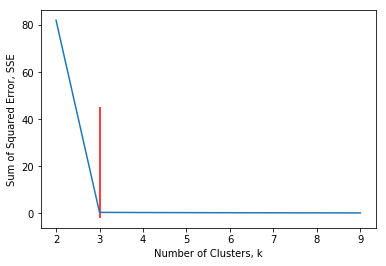

In [116]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# SSE is initialize with empty values
# n_clusters is the "k" 
sse = {}
for n_cluster1 in range(2, 10):
    kmeans1 = KMeans(n_clusters = n_cluster1, max_iter = 200).fit(se_grouped_clustering)
    se_grouped_clustering["clusters"] = kmeans1.labels_
    
    # The inertia is the sum of distances of samples to their closest cluster centre
    sse[n_cluster1] = kmeans1.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of Clusters, k")
plt.ylabel("Sum of Squared Error, SSE")
# vertical line
plt.vlines(3, ymin = -2, ymax = 45, colors = 'red')
plt.show()

We used 200 iterations and concluded that 3 clusters would be quite optimal since the SSE is falling till Cluster number 3 in high range.

**3.2.6 Visualizing the Resulting Clusters**


In [117]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(se_clusters['Latitude'], se_clusters['Longitude'], se_clusters['Location'], se_clusters['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=20,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

display(map_clusters)

### Cluster 1

In [118]:
se_clusters.loc[se_clusters['Cluster Labels'] == 0, se_clusters.columns[[1] + list(range(5, se_clusters.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Southwark,0,Café,Coffee Shop,Pub,Hotel,Theater,Italian Restaurant,Park,Bar,Art Gallery,Street Food Gathering
6,Southwark,0,Café,Coffee Shop,Pub,Hotel,Theater,Italian Restaurant,Park,Bar,Art Gallery,Street Food Gathering
7,Southwark,0,Café,Coffee Shop,Pub,Hotel,Theater,Italian Restaurant,Park,Bar,Art Gallery,Street Food Gathering
8,Southwark,0,Coffee Shop,Hotel,Pub,Italian Restaurant,Theater,Bar,Art Museum,Seafood Restaurant,Street Food Gathering,Scenic Lookout
18,Lambeth,0,Coffee Shop,Hotel,Pub,Italian Restaurant,Theater,Bar,Art Museum,Seafood Restaurant,Street Food Gathering,Scenic Lookout
22,Southwark,0,Coffee Shop,Pub,Italian Restaurant,Hotel,Café,Theater,Street Food Gathering,Bar,Pizza Place,Art Gallery
23,Southwark,0,Coffee Shop,Pub,Italian Restaurant,Hotel,Café,Theater,Street Food Gathering,Bar,Pizza Place,Art Gallery
30,Southwark,0,Coffee Shop,Hotel,Pub,Italian Restaurant,Theater,Bar,Art Museum,Seafood Restaurant,Street Food Gathering,Scenic Lookout


### Cluster 2

In [119]:
se_clusters.loc[se_clusters['Cluster Labels'] == 1, se_clusters.columns[[1] + list(range(5, se_clusters.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Lewisham,1,Pub,Coffee Shop,Café,Park,Bar,Gastropub,Pizza Place,Italian Restaurant,Gym / Fitness Center,Turkish Restaurant
2,Lewisham,1,Pub,Coffee Shop,Café,Bar,Park,Garden,Vietnamese Restaurant,History Museum,Gym / Fitness Center,Brewery
14,Lewisham,1,Pub,Café,Gastropub,Park,Coffee Shop,Garden,Food Truck,Supermarket,Fish & Chips Shop,Restaurant
16,Lewisham,1,Pub,Café,Coffee Shop,Park,Gastropub,Food Truck,Gym / Fitness Center,Fish & Chips Shop,Italian Restaurant,Bar
17,Lewisham,1,Pub,Café,Coffee Shop,Park,Gastropub,Food Truck,Gym / Fitness Center,Fish & Chips Shop,Italian Restaurant,Bar
20,Lewisham,1,Pub,Café,Gastropub,Park,Coffee Shop,Garden,Food Truck,Supermarket,Fish & Chips Shop,Restaurant
21,Lewisham,1,Pub,Coffee Shop,Café,Italian Restaurant,Bar,Gym / Fitness Center,Gastropub,Park,Vietnamese Restaurant,Brewery
28,Southwark,1,Pub,Brewery,Coffee Shop,Park,Bar,Vietnamese Restaurant,Café,Gym / Fitness Center,Bakery,Food Truck
33,Lewisham,1,Pub,Coffee Shop,Café,Park,Bar,Gastropub,Pizza Place,Italian Restaurant,Gym / Fitness Center,Turkish Restaurant
34,Southwark,1,Pub,Brewery,Coffee Shop,Park,Bar,Vietnamese Restaurant,Café,Gym / Fitness Center,Bakery,Food Truck


### Cluster 3

In [120]:
se_clusters.loc[se_clusters['Cluster Labels'] == 2, se_clusters.columns[[1] + list(range(5, se_clusters.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,Lewisham,2,Pub,Grocery Store,Café,Park,Italian Restaurant,Fish & Chips Shop,Fast Food Restaurant,Coffee Shop,Supermarket,Train Station
19,Lewisham,2,Pub,Grocery Store,Café,Park,Italian Restaurant,Fish & Chips Shop,Fast Food Restaurant,Coffee Shop,Supermarket,Train Station
26,Lewisham,2,Grocery Store,Park,Supermarket,Café,Pub,Coffee Shop,Fast Food Restaurant,Gas Station,Italian Restaurant,Bus Stop
32,Lewisham,2,Grocery Store,Park,Supermarket,Café,Pub,Coffee Shop,Fast Food Restaurant,Gas Station,Italian Restaurant,Bus Stop
44,Lewisham,2,Grocery Store,Park,Supermarket,Café,Pub,Coffee Shop,Fast Food Restaurant,Gas Station,Italian Restaurant,Bus Stop
45,Lewisham,2,Pub,Grocery Store,Café,Park,Italian Restaurant,Fish & Chips Shop,Fast Food Restaurant,Coffee Shop,Supermarket,Train Station


## 4. My Results


The following are the highlights of the 3 clusters above:

1. Pubs, Coffee shops and Grocery Stores are highly popular in Lewisham and area of Southwark.
2. For restaurants we can say that italian restaurants seem to be quie popular in SE.
3. This results suprisingly shows that even though there is such a high range of different ethnicities in SE, theres no clear direction or tendency for african restaurants.
4. Publs are quite well presented .

## 5. Conclusion


Since we just had a limited range of data available we could not conclude if the best option would be to start an african business in the area of Lewisham. What we can say is that other kind of social spots are more popular than typical "african restaurants. 

Further on we have to accept the limitations of our data in kind of different category features for our polation such as crime rate, interest of food etc.